In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from os.path import exists
if not exists('fmix.zip'):
    !wget -O fmix.zip https://github.com/ecs-vlc/fmix/archive/master.zip
    !unzip -qq fmix.zip
    !mv FMix-master/* ./
    !rm -r FMix-master

--2020-06-06 04:44:34--  https://github.com/ecs-vlc/fmix/archive/master.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ecs-vlc/FMix/zip/master [following]
--2020-06-06 04:44:34--  https://codeload.github.com/ecs-vlc/FMix/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘fmix.zip’

fmix.zip                [   <=>              ] 967.65K  1.86MB/s    in 0.5s    

2020-06-06 04:44:35 (1.86 MB/s) - ‘fmix.zip’ saved [990875]



In [0]:
!pip install -q kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "virajbagal"
os.environ['KAGGLE_KEY'] = "668ae848051438ff559726906387dd6d"

In [0]:
!kaggle datasets download -d virajbagal/chestxray14-256x256

 99% 3.64G/3.66G [01:08<00:00, 49.8MB/s]
100% 3.66G/3.66G [01:08<00:00, 56.9MB/s]


In [0]:
print(os.listdir('/content'))

['.config', 'implementations', 'gdrive', 'utils', 'README.md', 'fmix_example.png', 'experiments', 'notebooks', 'fmix_3d.gif', 'datasets', 'analysis', 'chestxray14-256x256.zip', 'fmix.py', 'trainer.py', 'LICENSE', 'requirements.txt', 'hubconf.py', 'models', 'fmix.zip', 'sample_data']


In [0]:
!unzip /content/chestxray14-256x256.zip

Streaming output truncated to the last 5000 lines.
  inflating: 00028897_015.png        
  inflating: 00028897_016.png        
  inflating: 00028897_017.png        
  inflating: 00028897_018.png        
  inflating: 00028897_019.png        
  inflating: 00028897_020.png        
  inflating: 00028898_000.png        
  inflating: 00028899_000.png        
  inflating: 00028899_001.png        
  inflating: 00028899_002.png        
  inflating: 00028900_000.png        
  inflating: 00028901_000.png        
  inflating: 00028901_001.png        
  inflating: 00028902_000.png        
  inflating: 00028902_001.png        
  inflating: 00028902_002.png        
  inflating: 00028902_003.png        
  inflating: 00028902_004.png        
  inflating: 00028902_005.png        
  inflating: 00028902_006.png        
  inflating: 00028902_007.png        
  inflating: 00028902_008.png        
  inflating: 00028903_000.png        
  inflating: 00028903_001.png        
  inflating: 00028903_002.png        

In [0]:
import numpy as np
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import ast

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tfm
from torchvision import models
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import BCEWithLogitsLoss
import torch
import random
from torch import nn

from fmix import sample_and_apply

plt.style.use('default')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
EPOCHS = 20
DEBUG = False
RESUME = False
LR = 1e-4
WD = 1e-5
PAT = 5
FACTOR = 0.1
BS = 16
NUM_CLASSES = 14
SIZE = 256
SEED = 42

MSDA = 'fmix'     # Choose one amongst mixup,fmix,cutmix and None
ALPHA = 1        # Parameter for Beta Distribution
DELTA = 3        # Decay Power for Fmix
SHAPE = (256,256)       # Shape of masks. Should be same as shape of image. For FMix

if DEBUG:
    EPOCHS = 1

DIR = '/content/gdrive/My Drive/ChestXray14/'

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
 
seed_everything(SEED)

In [0]:
def mixup(imgs, labels, alpha):
  lam = np.random.beta(alpha,alpha)
  index = torch.randperm(len(imgs))
  shuffled_imgs = imgs[index]
  shuffled_labels = labels[index]
  new_imgs = lam*imgs + (1-lam)*shuffled_imgs

  return new_imgs, shuffled_labels, lam 

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    return new_data, shuffled_target, lam

In [0]:
invalid = pd.read_csv(DIR+'invalid.txt', sep=' ', header=None)
invalid_list = []

invalid_list.append(ast.literal_eval(invalid.values[0][0][1:-1]).split('/')[-1])
for i in range(518):
  invalid_list.append(ast.literal_eval(invalid.values[0][i+1][:-1]).split('/')[-1])  

In [0]:
train_idx = np.concatenate(pd.read_csv(DIR+'train_val_list.txt', sep=' ', header=None).values)
test_idx = np.concatenate(pd.read_csv(DIR+'test_list.txt', sep=' ', header=None).values)

all_xray_df = pd.read_csv(DIR+'Data_Entry_2017_v2020.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/content','*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112121 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,/content/00022260_003.png
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,64,M,AP,2500,2048,0.168,0.168,/content/00012048_007.png
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,/content/00014352_005.png


In [0]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
13396,00003489_002.png,,0,3489,49,M,PA,2500,2048,0.171,0.171,/content/00003489_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78570,00019271_053.png,Atelectasis,53,19271,54,M,AP,2500,2048,0.168,0.168,/content/00019271_053.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66807,00016508_048.png,,48,16508,51,F,AP,2500,2048,0.168,0.168,/content/00016508_048.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
class ChestDataset(Dataset):
    def __init__(self, df, transform, mode='train'):
        self.label_df = df[all_labels].values
        self.path_df = df['path'].values
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.path_df)
    
    def __getitem__(self, idx):
        path = self.path_df[idx]
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            
        img = np.stack([img,img,img], -1)
        
        if self.transform:
            img = self.transform(img)
            

        label = self.label_df[idx]
            

        return img, torch.tensor(label, dtype=torch.float)

In [0]:
train_tfm = tfm.Compose([tfm.ToPILImage(),
                         tfm.ToTensor(),
                         tfm.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

val_tfm = tfm.Compose([tfm.ToPILImage(),
                       tfm.ToTensor(),
                       tfm.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

In [0]:
all_xray_df = all_xray_df[~all_xray_df['Image Index'].isin(invalid_list)].reset_index(drop=True)
train_valdf = all_xray_df[all_xray_df['Image Index'].isin(train_idx)].reset_index(drop=True)
valdf = train_valdf.sample(n=10000, random_state=SEED)
traindf = train_valdf[~train_valdf['Image Index'].isin(list(valdf['Image Index'].values))]
testdf = all_xray_df[all_xray_df['Image Index'].isin(test_idx)].reset_index(drop=True)

In [0]:
train_dataset = ChestDataset(traindf, train_tfm)
val_dataset = ChestDataset(valdf, val_tfm, mode='val')

trainloader = DataLoader(train_dataset, batch_size=BS, num_workers=4, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BS, num_workers=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

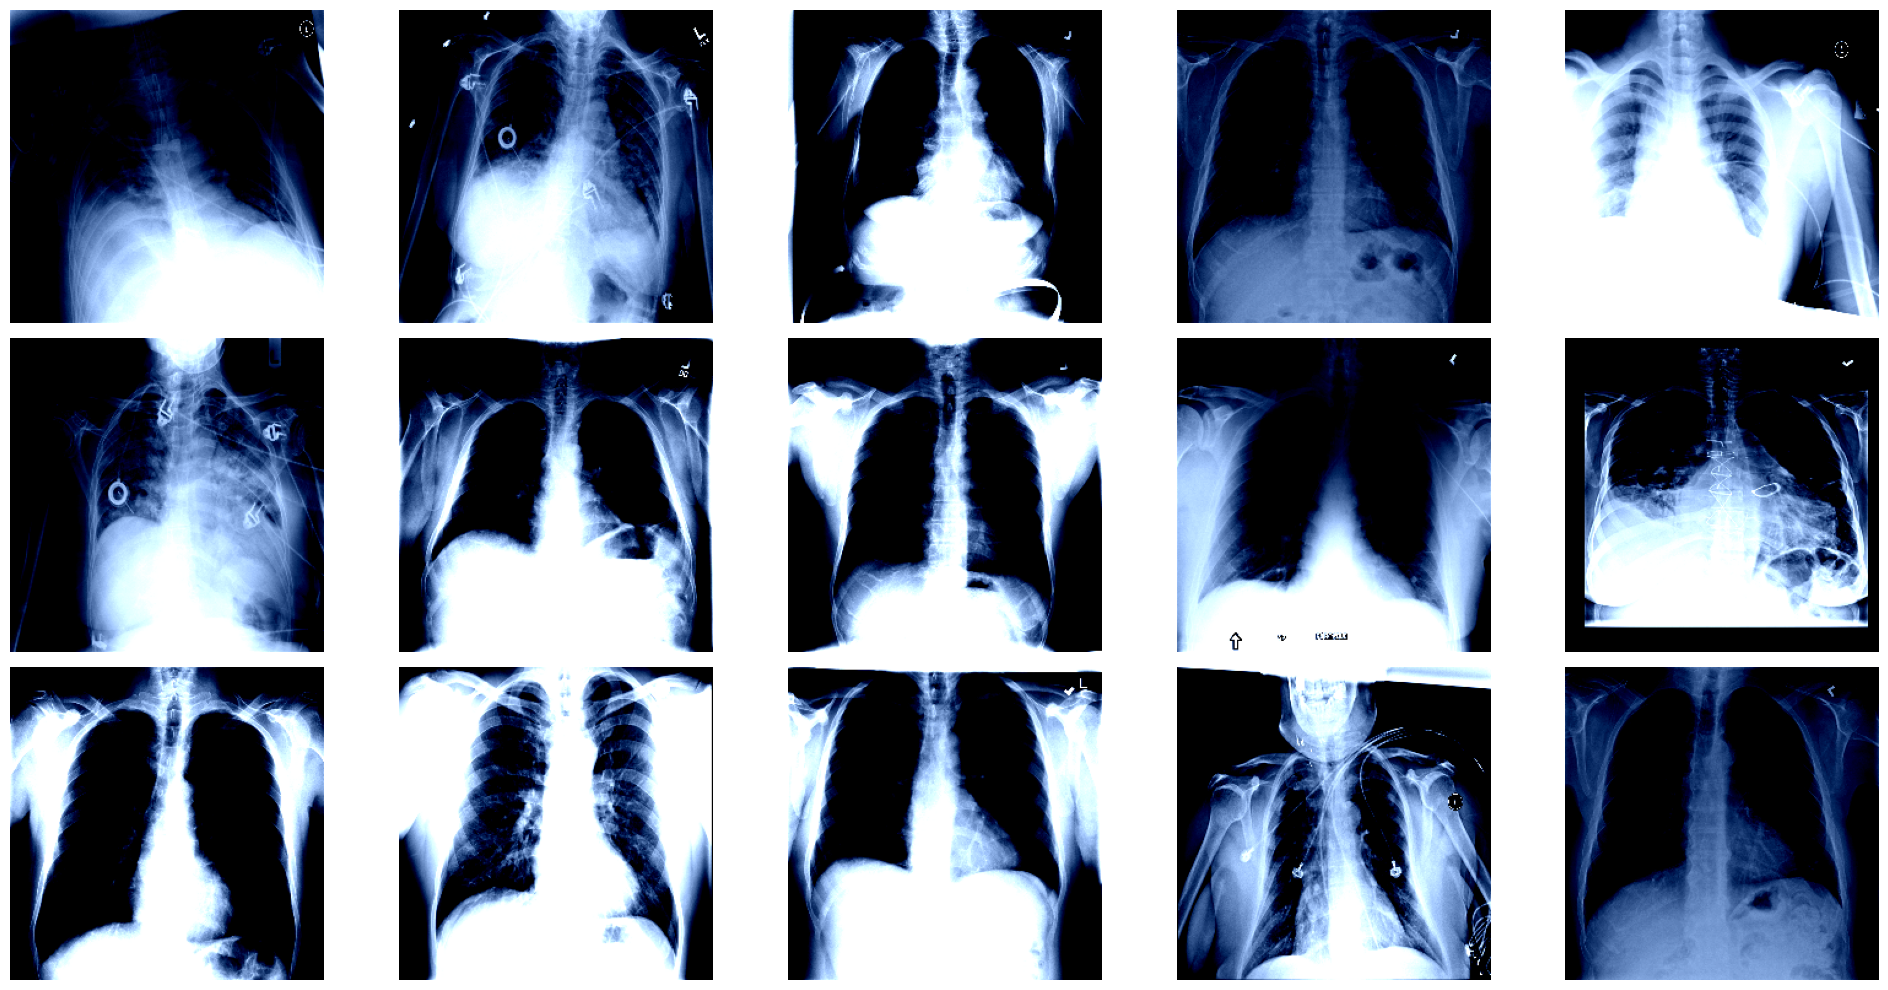

In [0]:
plt.figure(figsize=(20,10))

for i in range(15):
    plt.subplot(3,5,i+1)
    idx = np.random.randint(len(trainloader))
    img, _ = train_dataset[idx]
    plt.imshow(img.numpy().transpose(1,2,0), cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
plt.savefig('')
plt.show()

In [0]:
model = models.densenet121(pretrained=True)
in_feat = model.classifier.in_features
model.classifier = nn.Linear(in_feat, NUM_CLASSES)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WD)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=PAT, factor = FACTOR, mode='min') # Reduce lr by 0.1 factor after every 5 epochs
criterion = BCEWithLogitsLoss()

def get_lr(optimizer):
  lr_list = []
  for p in optimizer.param_groups:
    lr_list.append(p['lr'])

  return lr_list[0]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [0]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_one_epoch(epoch, dataloader, model, criterion, optimizer, scheduler, msda=MSDA):
  train_loss = 0
  predictions = []
  truth = []
  auc_list = []
  length = len(dataloader)
  model.train()
  optimizer.zero_grad()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False, desc=f'Epoch {epoch+1}/{EPOCHS}')

  for i, (img, label) in iterator:

    if msda=='fmix':
      # 'lam' is sampled from beta distribution with parameter alpha. 
      img, index, lam = sample_and_apply(img, alpha=ALPHA, decay_power=DELTA, shape=SHAPE)
      # 'img' is the batch with fmixed images
      img = img.type(torch.FloatTensor)    
      shuffled_label = label[index].to(device)
    elif msda=='mixup':
      img, shuffled_label, lam = mixup(img, label, alpha=ALPHA)
      shuffled_label = shuffled_label.to(device)
    elif msda=='cutmix':
      img, shuffled_label, lam = cutmix(img, label, alpha=ALPHA)
      shuffled_label = shuffled_label.to(device)


    img = img.to(device)
    label = label.to(device)

    output = model(img)
    
    if msda in ['fmix','mixup','cutmix']:
      loss = lam*criterion(output, label) + (1-lam)*criterion(output, shuffled_label)
    elif msda is None: 
      loss = criterion(output, label)


    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_loss += loss.item()/length

    pred = torch.sigmoid(output)
    predictions.append(pred.detach().cpu().numpy())
    truth.append(label.detach().cpu().numpy())

    if DEBUG:
      if i==100:
        break

    if scheduler:
      scheduler.step()

  predictions = np.concatenate(predictions)
  truth = np.concatenate(truth)

  for i in range(NUM_CLASSES):
    auc_list.append(roc_auc_score(truth[:,i], predictions[:,i], average='weighted'))

  return train_loss, auc_list

def validate_one_epoch(epoch, dataloader, model, criterion):
  val_loss = 0
  predictions = []
  truth = []
  auc_list = []
  length = len(dataloader)
  model.eval()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False, desc=f'Epoch {epoch+1}/{EPOCHS}')

  for i, (img, label) in iterator:
    img = img.to(device)
    label = label.to(device)
    output = model(img)

    loss = criterion(output,label)
    val_loss += loss.item()/length

    pred = torch.sigmoid(output)
    predictions.append(pred.detach().cpu().numpy())   
    truth.append(label.detach().cpu().numpy())
    
    if DEBUG:
      if i==100:
        break

  predictions = np.concatenate(predictions)
  truth = np.concatenate(truth)
    
  for i in range(NUM_CLASSES):
    auc_list.append(roc_auc_score(truth[:,i], predictions[:,i], average='weighted'))

  return val_loss, auc_list


def test_model(dataloader, model):
  val_loss = 0
  predictions = []
  truth = []
  auc_list = []
  pr_list = []
  length = len(dataloader)
  model.eval()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False)

  for i, (img, label) in iterator:
    batch_len = len(img)
    img = img.view(-1, 3, CROP_SIZE, CROP_SIZE)
    img = img.to(device)
    label = label.to(device)
    
    output = model(img)
    output = output.view(batch_len, 10, -1).mean(1)
    
    pred = torch.sigmoid(output)
    predictions.append(pred.detach().cpu().numpy())   
    truth.append(label.detach().cpu().numpy())

  predictions = np.concatenate(predictions)
  truth = np.concatenate(truth)
  for i in range(NUM_CLASSES):
    auc_list.append(roc_auc_score(truth[:,i], predictions[:,i], average='weighted'))
    pr_list.append(average_precision_score(truth[:,i], predictions[:,i], average='weighted'))

  return val_loss, auc_list, pr_list, truth, predictions

In [0]:
best_loss = np.inf
best_auc = 0

model.to(device)

for epoch in range(EPOCHS):
  
  if RESUME:
    epoch = resume_epoch + 1

  t_loss, t_auc = train_one_epoch(epoch, trainloader, model, criterion, optimizer, scheduler=None)
  lr = get_lr(optimizer)
  print('Epoch {}/{} (train) || Loss: {:.4f} AUC: {:.4f} LR: {:.5f}'.format(epoch+1, EPOCHS, t_loss, np.mean(t_auc), lr))
    
  v_loss, v_auc = validate_one_epoch(epoch, valloader, model, criterion)
  print('Epoch {}/{} (validation) || Loss: {:.4f} AUC: {:.4f}'.format(epoch+1, EPOCHS, v_loss, np.mean(v_auc)))

  scheduler.step(v_loss)  

  content1 = ''
  for key, val in zip(all_labels, v_auc):
      content1 = content1 + ' {}: {}'.format(key, val)

  content2 = 'Train Loss: {:.4f} Val Loss: {:.4f}\
  Mean Train AUC: {:.4f} Mean Val AUC: {:.4f}'.format(t_loss, v_loss, np.mean(t_auc), np.mean(v_auc))
  content = content2 + content1 

  recorder={}

  recorder['epoch'] = epoch
  recorder['model'] = model.state_dict()
  recorder['optimizer'] = optimizer.state_dict()
  recorder['scheduler'] = scheduler.state_dict()

  torch.save(recorder, DIR+'chestxray14_d121_fmix_recorder.pth')

  with open(DIR+'chestxray14_d121_fmix.txt', 'a') as logger:
    logger.write(content + '\n')

  if v_loss<best_loss:
    torch.save(model.state_dict(), DIR+'chestxray14_d121_fmix_loss.pth')
    best_loss = v_loss

  if np.mean(v_auc)>best_auc:
    torch.save(model.state_dict(), DIR+'chestxray14_d121_fmix_auc.pth') 
    best_auc = np.mean(v_auc)

KeyboardInterrupt: ignored